Highlights of this notebook are:

- **Describe and visualize your data**
    - The .describe() method gives you easy access to important statistics for each column, including the mean, std, variance, and other metrics.
    - You can plot the histogram of the entire dataframe by simply using df.hist(). bins is used to tell you how many "stacks" are in each histogram.
    - sklearn makes it easy to do stratified sampling. While random sampling is generally fine when you have a large dataset, stratified sampling can help ensure that you ensure that your test and train sets are representative of the whole dataset. 
    - Plotting your data using .plot() and setting the hyperparameter cmap='jet' gives your visualization cool colors!
- **Data Preprocessing**
    - There are several important preprocessing techniques that can be combined using sklearn's Pipeline and ColumnTransformer transformers (remember transformers are estimators with fit and transform methods, as well as fit_transform). fit_transform is used to transform the training data using the mean and variance of the training data; transform is used to transform the test data using the mean and variance of the training data - this is done to keep the distribution of the test data unknown to the model.
        - transform: Perform standardization by centering and scaling.
        - fit: Compute the mean and std to be used for later scaling.
        - fit_transform: Fit to data, then transform it.
    - Pipeline is generally used to combine the preprocessing for numerical attributes.
    - The pipeline you create can be input into ColumnTransformer, which can simultaneously execute the pipeline and deal with non-numerical attributes (e.g. one-hot encoding them)
    - You can make your own transformer by constructing a class and defining init, fit, transform, and fit_transform methods. In our example, we explicitly define fit and transform, and then get fit_transform by defining TransformerMixin as a base class.
- **Fitting and Testing a Model**
    - Choose your model, then fit the model using the .fit() method.
    - Cross validation is important to ensure you're not overfitting your model to the training data. GridSearchCV automatically does cross validation as well as fine-tunes the model by doing a grid search on the parameters your give it. (This is good when the search space is small, otherwise consider using RandomizedSearchCV). 
    - CV Scores for each model cane be obtained by using grid_search.cv_results_. Scoring method is determined by the scoring hyperparameter (eg scoring='neg_mean_squared_error').
    - The best model/parameter combination can be found using grid_search.best_estimator_.
    - Feature importances can be found using grid_search.best_estimator_.feature_importances_.
    - After testing, it's good to create a 95% confidence interval around the final test rmse to demonstrate its efficacy as compared to other models
- **Launching a Model into Production**
    - It is good to retrain your model on fresh data because the model may become stale (data seasonality or other changes that cannot be accounted for can be effectively incorporated into the model by retraining on new data).

In [1]:
import os
import tarfile
from six.moves import urllib

# Download Data

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
fetch_housing_data()
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

# Describe and Visualize Data

In [6]:
housing.describe()
#this ignores null values - therefore count for total bedrooms 

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


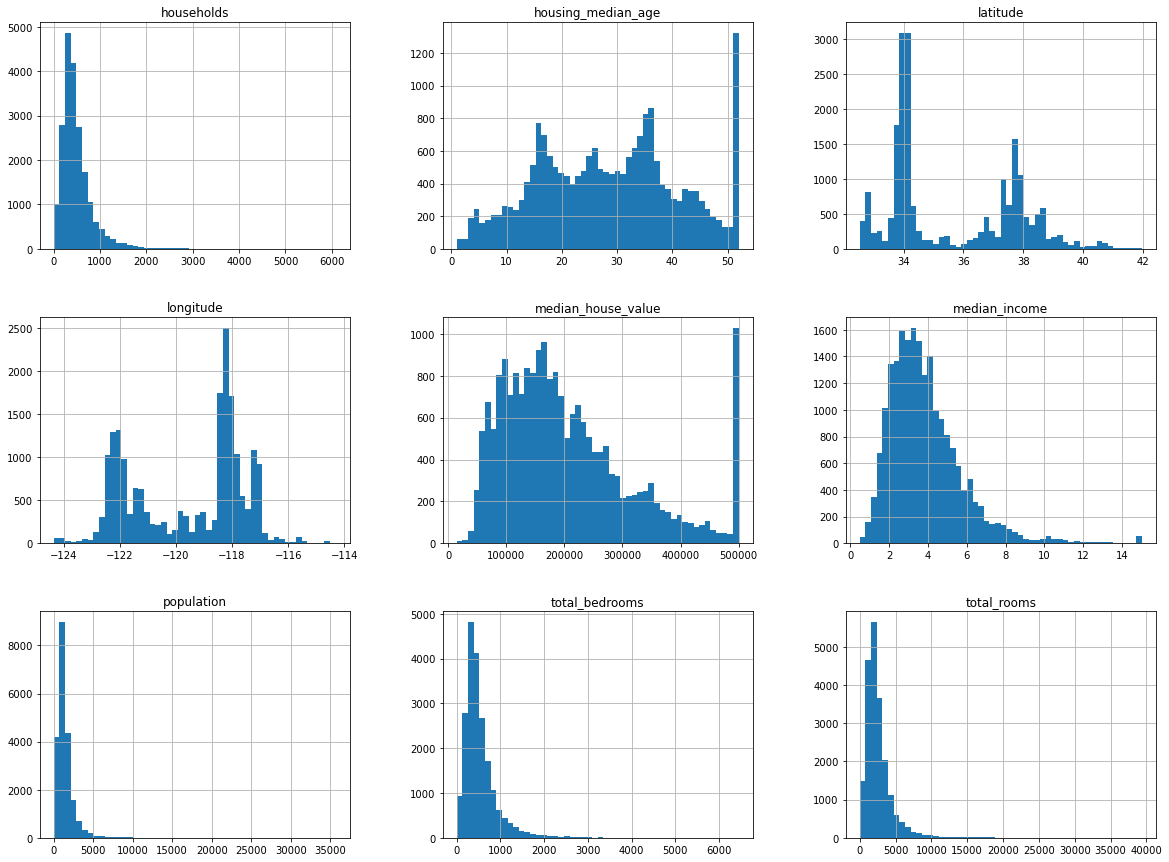

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [8]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

#random state is used to ensure you use the same train and test sets each time you load the dataset

In [9]:
#Stratified sampling aims at splitting a data set so that each split is similar with respect to something. 
#In a classification setting, it is often chosen to ensure that the train and test sets have approximately the same 
    #percentage of samples of each target class as the complete set.
#pd.cut makes strata (income categories in this case) so you can determine how to split up data
#note that the results are based on labels, and counts are based on number of instances under those labels
import numpy as np
housing["income_cat"] = pd.cut(housing["median_income"],
                                   bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                                labels=[1, 2, 3, 4, 5])
housing['income_cat'].value_counts().reset_index()

,index,income_cat
0,3,7236
1,2,6581
2,4,3639
3,5,2362
4,1,822


In [10]:
#this does stratified sampling based on strata created using pd.cut
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 
for train_index, test_index in split.split(housing, housing["income_cat"]):
        strat_train_set = housing.loc[train_index]
        strat_test_set = housing.loc[test_index]

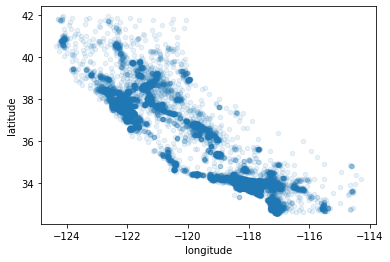

In [12]:
#we can use alpha to determine the opacity of the dots - this reveals a trend about the housing density in CA
#note that x (longitude) and y (latitude) are columns in housing
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

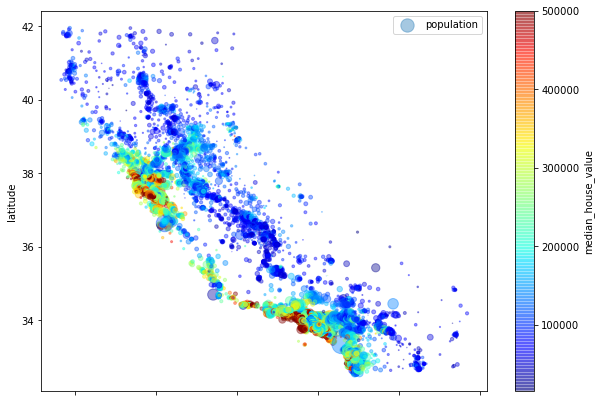

In [13]:
#s determines size of dots, category tells you how to determine size
    #s=housing["population"] <-> size determined by population
#c determines color based on value given
    #c="median_house_value" <-> price determines colors, cmap=plt.get_cmap("jet") ranges from blue to red low to high

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
        s=housing["population"]/100, label="population", figsize=(10,7),
        c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    )
plt.legend()

In [ ]:
#use scatter matrix function to check correlation between attributes
#diagnoals show histogram (obvious 100# correlation), off-diagonals show correlation
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms",
                  "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

# Data Preprocessing

In [14]:
# split targets (labels) and features
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [15]:
#can use OrdinalEncoder to make variables with text into numbers
from sklearn.preprocessing import OrdinalEncoder 
ordinal_encoder = OrdinalEncoder()

housing_cat = housing[["ocean_proximity"]]

housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat) #this means ordinal_encoder is a transformer(type of estimator)
housing_cat_encoded[:10], housing_cat[:10]

(array([[0.],
        [0.],
        [4.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.]]),
       ocean_proximity
 17606       <1H OCEAN
 18632       <1H OCEAN
 14650      NEAR OCEAN
 3230           INLAND
 3555        <1H OCEAN
 19480          INLAND
 8879        <1H OCEAN
 13685          INLAND
 4937        <1H OCEAN
 4861        <1H OCEAN)

In [16]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [17]:
#while such encoding, i.e. labeling values 1,2,3.. works well for categories on a gradient of values, 
    #i.e. bad, good, excellent..., this does not work for our case
#therefore onehot encoding is better
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat) 
housing_cat_1hot
#note that the result is in a sparse matrix (zeros not stored) to save memory (though it can be converted to np array)

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [18]:
#can create custom transformers (this one is to add features containing mixtures of other features, eg bedrooms per house)
#methods needed for transformer: fit, transform, and fit_transform. 
#first two are explicitly defined, the last is obtained by making TransformerMixin a base class
#BaseEstimator is added as base class to obtain get_params and set_params, which are useful for hyperparameter tuning
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room 
    def fit(self, X, y=None):
        return self # nothing else to do 
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix] 
        population_per_household = X[:, population_ix] / X[:, households_ix] 
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household,population_per_household,bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [19]:
#sklearn has Pipeline class to combine all data preprocessing
#impute deals with missing values, scaler puts all data on same scale
#NOTE ON SCALING: MinMax just divides by max value (all values btwn 0 and 1, but this can be changed with feature_range), 
    #StandardScaler subtracts mean and divides by standard deviation (mean 0, unit variance)
housing_num = housing.drop("ocean_proximity", axis=1)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy="median")),
            ('attribs_adder', CombinedAttributesAdder()),
            ('std_scaler', StandardScaler()),
        ])

#note that to execute the transformer, we call .fit_transform
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [20]:
housing_num.head(1)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,income_cat
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,2


In [21]:
housing_num_tr[0], housing_num_tr.shape

(array([-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.95445595, -0.31205452,
        -0.08649871,  0.15531753]),
 (16512, 12))

In [22]:
#Can combine categorical and numerical column preprocessing with ColumnTransformer
from sklearn.compose import ColumnTransformer 
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
             #("transformer_name", transformer, column_names)
             ("num", num_pipeline, num_attribs),
             ("cat", OneHotEncoder(), cat_attribs),
         ])
housing_prepared = full_pipeline.fit_transform(housing)

# Build, Train, and Test a Model

### Linear Regression

In [23]:
#fit the model
from sklearn.linear_model import LinearRegression 
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [24]:
# test some individual examples
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [203682.37379543 326371.39370781 204218.64588245  58685.4770482
 194213.06443039]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [25]:
#get rmse
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)

#the rmse is very high, so it is likely that the model is underfitting the data
#note that the rmse is 68k, when the median housing price is on the order of 200k (see housing.describe())
lin_rmse

68376.64295459937

### Decision Tree

In [26]:
from sklearn.tree import DecisionTreeRegressor 
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [27]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)

#the rmse is 0, so the decision tree likely overfits to training data
tree_rmse

0.0

In [28]:
#check validity of model by doing 10-fold cross-validation on training data
#cross_val_score returns the score for each fold based on the scoring criteria (here we use the negative mse)
#note that housing_prepared is the pipelined/processed version of housing; 
    #housing is obtained from housing = strat_train_set.drop("median_house_value", axis=1)
    #housing is thus from the stratified sampling of the train set
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [31]:
def display_scores(scores):
   print("Scores:", scores)
   print("Mean:", scores.mean())
   print("Standard deviation:", scores.std())

#decision tree does not perform nearly as well when tested with x-val
display_scores(tree_rmse_scores)

Scores: [68789.97843587 66583.59979958 70438.55967748 67800.68288234
 70258.62217286 75628.99817394 69887.24109071 70449.49474047
 77010.65895404 69344.95488802]
Mean: 70619.27908153067
Standard deviation: 3096.3833114453246


### Random Forest

In [36]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)

scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)

#random forest performs better than decision tree (mean score is 50k vs 70k)
display_scores(forest_rmse_scores)

Scores: [49474.17800245 47625.39297    50133.48376281 51820.39085031
 49877.76875271 53429.39984734 48773.89156718 48057.86497068
 52820.90826107 50523.62163728]
Mean: 50253.69006218288
Standard deviation: 1840.8139176619718


In [37]:
#forest still tends to overfit given the training rmse is significantly less
forest_rmse

18615.369526644638

### RF Grid Search

In [38]:
from sklearn.model_selection import GridSearchCV

#first optimize based on parameters in first dictionary (3 n_estimators, 4 max_features -> 3x4=12 total combos)
#then optimize next dictionary from scratch, where bootstrap = false (2 n_estimators, 3 max_features -> 2x3=6 total combos)
#12+6=18 total models; with 5-fold cv, 18x5=90 rounds of training
param_grid = [
        {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
        {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                               scoring='neg_mean_squared_error',
                               return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [41]:
#can see best estimator and params
grid_search.best_params_, grid_search.best_estimator_

({'max_features': 8, 'n_estimators': 30},
 RandomForestRegressor(max_features=8, n_estimators=30))

In [42]:
#can also look at all of the trees created (there should be 18, since 12+6=18)
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64369.79470871667 {'max_features': 2, 'n_estimators': 3}
55873.90381524183 {'max_features': 2, 'n_estimators': 10}
53203.885499071024 {'max_features': 2, 'n_estimators': 30}
61503.398694961164 {'max_features': 4, 'n_estimators': 3}
53750.637745190645 {'max_features': 4, 'n_estimators': 10}
51638.34235452476 {'max_features': 4, 'n_estimators': 30}
60147.175975114005 {'max_features': 6, 'n_estimators': 3}
53240.25905815541 {'max_features': 6, 'n_estimators': 10}
51050.12497582836 {'max_features': 6, 'n_estimators': 30}
60039.27591402615 {'max_features': 8, 'n_estimators': 3}
52579.9153646969 {'max_features': 8, 'n_estimators': 10}
50607.81557511138 {'max_features': 8, 'n_estimators': 30}
62670.31546653862 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54430.15908189295 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
61356.26363352558 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53507.789971259765 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [44]:
grid_search.cv_results_

{'mean_fit_time': array([0.07676706, 0.2366488 , 0.70608401, 0.10236301, 0.35294261,
        1.03855147, 0.14041524, 0.49628735, 1.54682913, 0.22261958,
        0.66715317, 1.99908509, 0.10712667, 0.35650773, 0.14483943,
        0.4911871 , 0.18239779, 0.65062356]),
 'std_fit_time': array([0.01323898, 0.02443158, 0.0269647 , 0.00646691, 0.02264608,
        0.07906387, 0.00313683, 0.03029053, 0.07885866, 0.02391589,
        0.02822105, 0.0456516 , 0.00354617, 0.00592164, 0.00370729,
        0.01630565, 0.00914961, 0.06343551]),
 'mean_score_time': array([0.00419259, 0.0138576 , 0.03389783, 0.00398059, 0.01192646,
        0.03074374, 0.00372972, 0.01038685, 0.03565555, 0.00510774,
        0.0117568 , 0.03637972, 0.0051228 , 0.01265869, 0.00474257,
        0.0133574 , 0.00480824, 0.01617966]),
 'std_score_time': array([0.00047235, 0.00183563, 0.00259715, 0.00059968, 0.00297839,
        0.00191091, 0.00038338, 0.00089993, 0.00411063, 0.00092964,
        0.0010851 , 0.00835133, 0.00058251, 

In [45]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.19521041e-02, 5.51952192e-02, 4.57781090e-02, 1.58397111e-02,
       1.61349920e-02, 1.47751463e-02, 1.45845949e-02, 3.68663685e-01,
       8.72741329e-02, 2.81278760e-02, 1.10284514e-01, 3.85753703e-02,
       4.34999346e-03, 1.33163671e-01, 4.02978716e-05, 1.90810002e-03,
       3.35248326e-03])

In [46]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0]) #gets non-numerical (categorical) features
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

#median income is the most important variable!

[(0.36866368478112027, 'median_income'),
 (0.1331636708904648, 'INLAND'),
 (0.11028451384963367, 'pop_per_hhold'),
 (0.0872741329198177, 'income_cat'),
 (0.061952104061098766, 'longitude'),
 (0.055195219190240695, 'latitude'),
 (0.04577810901591991, 'housing_median_age'),
 (0.03857537030956091, 'bedrooms_per_room'),
 (0.028127875994152608, 'rooms_per_hhold'),
 (0.016134992049824808, 'total_bedrooms'),
 (0.015839711107846616, 'total_rooms'),
 (0.014775146337607776, 'population'),
 (0.01458459489257445, 'households'),
 (0.0043499934554109875, '<1H OCEAN'),
 (0.0033524832575694817, 'NEAR OCEAN'),
 (0.0019081000156029686, 'NEAR BAY'),
 (4.029787155349414e-05, 'ISLAND')]

In [50]:
#Testing the 
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions) 
final_rmse = np.sqrt(final_mse) # => evaluates to 47,730.2

In [51]:
final_rmse

48751.544873043065

In [52]:
#We can generate a 95% confidence interval around the rmse to get a feel for how good our estimate of the final rmse is
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2

#lower bound is bottom 5% threshold, upper bound is top 5% threshold
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,loc=squared_errors.mean(),scale=stats.sem(squared_errors)))

array([46759.38941223, 50665.42960256])